# Database creation
This file is used to play with the data and once the objective is reached, functions will be written in .py files in order to be used by the model part of the project.

In [1]:
from astropy.io import fits
from tabulate import tabulate
from astropy.time import Time, TimeDelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset_creation_utils import *
# Retrieve the contrast curves from the database
path_db = 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/SPHERE_DC_DATA/'
foldername = '2MASS J01543773+0043005_DB_H23_2014-10-07_ird_specal_dc_cADI_softsorting_200967/'
filename = 'ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits'

if not os.path.exists(path_db):
    print('ERROR! Folder {} does not exist.'.format(path_db)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db, foldername)):
    print('ERROR! Folder {} does not exist.'.format(foldername))

if not os.path.exists(os.path.join(path_db, foldername, filename)):
    print('ERROR! File {} does not exist.'.format(filename))

# Example of how to read a fits file
with fits.open(os.path.join(path_db, foldername, filename)) as hdul:
    data = hdul[1].data #numpy record
    headers = hdul[1].header #dictionary
    print(data.dtype)
    # print(hdul[1].header['DATE-OBS'])
    # print(hdul[1].data['TARGET_NAME'])

(numpy.record, [('TARGET_NAME', 'S3'), ('LAM', 'S10'), ('PIXSCALE', 'S10'), ('NSIGMA', 'S3'), ('REPERTORY', 'S55'), ('SEPARATION', '>f4', (1148,)), ('NSIGMA_CONTRAST', '>f4', (1148,))])


Get a dataframe with the specified headers. Plots, summary statistics, ... can be computed if desired (not to be re-done each time).

In [2]:
header_list = ['ESO OBS ID', 'DATE-OBS', 'ESO OBS START', 'OBJECT', 'ESO TEL AMBI FWHM MEAN', 'ESO TEL TAU0 MEAN', \
    'ESO TEL AIRM MEAN', 'EFF_NFRA', 'EFF_ETIM', 'SR_AVG', 'ESO INS4 FILT3 NAME', \
        'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'SCFOVROT', 'SC MODE', \
            'ESO TEL AMBI RHUM', 'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', \
                'HIERARCH ESO TEL AMBI TEMP']

In [3]:
reload = False

if reload:
    df = get_df_with_headers(path_db, header_list, interpolate=True, compute_summary=False, write_headers=True, compute_plots=False, max_sep=3)
    # Save df to csv
    df.to_csv('df.csv')
else:
    df = pd.read_csv('df.csv', index_col=0)
    # Are saved as strings, convert to list of floats
    df['SEPARATION'] = df['SEPARATION'].apply(lambda x: [float(i) for i in x.replace('[', '').replace(']', '').split()])
    df['NSIGMA_CONTRAST'] = df['NSIGMA_CONTRAST'].apply(lambda x: [float(i) for i in x.replace('[', '').replace(']', '').split()])

# df

In [4]:
# Get the min and max dates 
min_date = df['DATE-OBS'].min()
max_date = df['DATE-OBS'].max()
print('Min date: {}, max date: {}'.format(min_date, max_date))

# Get the number of observations before april 2016
df_before_april = df[df['DATE-OBS'] < '2016-04-01']
print('Number of observations before april 2016: {}'.format(len(df_before_april)))

# Get the number of observations after april 2016
df_after_april = df[df['DATE-OBS'] >= '2016-04-01']
print('Number of observations after april 2016: {}'.format(len(df_after_april)))

Min date: 2014-07-13T09:43:44.923, max date: 2019-03-25T02:18:36.930
Number of observations before april 2016: 148
Number of observations after april 2016: 366


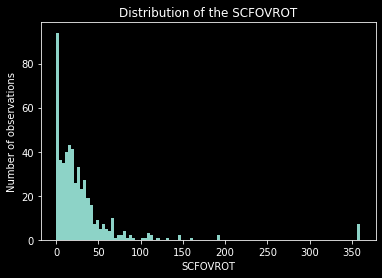

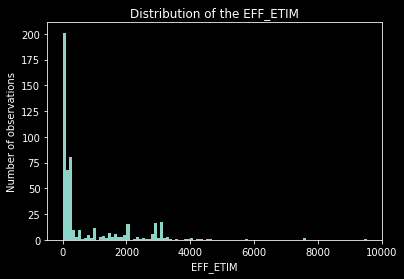

In [15]:
# Plot histogram of the wanted headers
hist_list = ['SCFOVROT', 'EFF_ETIM']

for hist in hist_list:
    try:
        plt.hist(df[hist], bins=100)
        plt.title("Distribution of the {}".format(hist))
        plt.xlabel(hist)
        plt.ylabel("Number of observations")
        plt.show()
    except KeyError:
        print("ERROR! Header {} does not exist.".format(hist))

This plot is a summary plot of all the contrast curves, no anomaly detection has been performed.

In [6]:
a = "[1 2 3]"
# Comvert string to list of floats
a = a.replace('[', '').replace(']', '').split()
a = [float(i) for i in a]
a

[1.0, 2.0, 3.0]

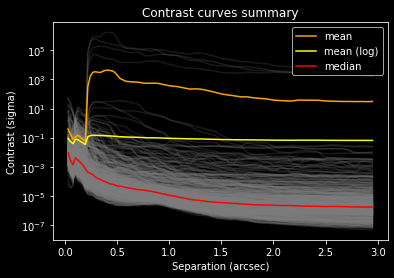

In [7]:
plot_contrast_curves_summary(path_db, df, filename='contrast_curves_summary_raw.png')

Now the sum of the absolute differences between the contrast curves and the median contrast curve (using log values) is used as deviation measure.

In [8]:
df['ABS DEV'] = get_abs_deviations_from_median(df)
# df

The distribution of these deviations is showed and some outliers can be observed.

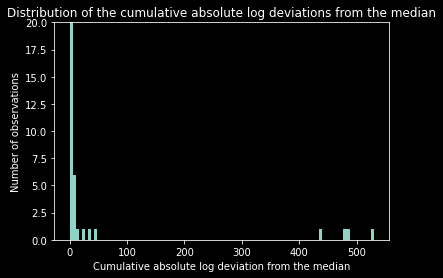

In [9]:
# Plot the distribution of the absolute deviations from the median
plt.hist(df['ABS DEV'], bins=100)	
# plt.xlim(0, 100)
plt.ylim(0, 20)
plt.title("Distribution of the cumulative absolute log deviations from the median")
plt.xlabel("Cumulative absolute log deviation from the median")
plt.ylabel("Number of observations")
plt.show()

The cut-off criterion has been chosen (arbitrarly) and a new summary plot has been computed in order to be compared to the previous one.

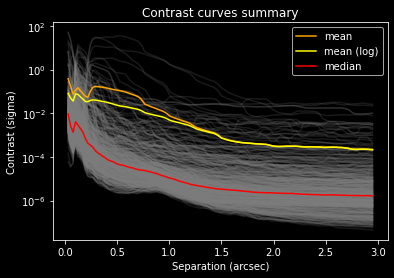

In [10]:
df_AD = remove_contrast_anomalies(path_db, df, threshold=100)

# Plot the new summary of the contrast curves
plot_contrast_curves_summary(path_db, df_AD, filename='contrast_curves_summary_anomaly_detection.png')

In [11]:
df_AD

,folder,ESO OBS ID,DATE-OBS,ESO OBS START,OBJECT,ESO TEL AMBI FWHM MEAN,ESO TEL TAU0 MEAN,ESO TEL AIRM MEAN,EFF_NFRA,EFF_ETIM,...,ESO TEL AMBI RHUM,HIERARCH ESO INS4 TEMP422 VAL,HIERARCH ESO TEL TH M1 TEMP,HIERARCH ESO TEL AMBI TEMP,ESO OBS STOP,SEPARATION,NSIGMA_CONTRAST,SIMBAD_FLUX_G,SIMBAD_FLUX_H,ABS DEV
0,++ CVN 3B_DB_H23_2018-09-14_ird_specal_dc_cADI...,2177825,2018-09-15T07:33:22.600,2018-09-15T06:29:28,CD-52 381,1.262950,0.002073,1.14378,3360.0,2813.000000,...,4.5,11.1,7.48,7.24,2018-09-15T07:16:21.000,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.0764733002, 0.00705791389, 0.00498788348, 0...",10.614176,8.530,0.034402
1,++ KOH 78_DB_H23_2016-04-03_ird_specal_dc_cADI...,1182440,2016-04-04T07:59:57.849,2016-04-04T07:26:07,ScoPMS_048,NaN,NaN,NaN,NaN,64.964733,...,36.5,15.9,12.55,13.33,2016-04-04T07:27:11.965,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.0136105987, 0.00510214264, 0.0023444712, 0....",14.683154,8.473,0.004896
2,++ SKF 1501_DB_H23_2015-04-11_ird_specal_dc_cA...,1182371,2015-04-12T07:15:49.844,2015-04-12T06:30:44,HIP_76629,NaN,NaN,NaN,NaN,71.469160,...,8.5,17.3,14.33,15.94,2015-04-12T06:31:55.469,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.00835001856, 0.0022740226, 0.000945013547, ...",7.677120,5.994,0.005167
3,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.950,2018-07-05T01:12:26,RXJ1846,2.310000,0.001700,1.35900,32.0,26.790000,...,33.0,10.7,7.45,8.43,2018-07-05T01:12:52.790,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.12483872, 0.07288619, 0.02093365, 0.0118967...",10.789814,8.469,4.846991
4,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.950,2018-07-05T01:12:26,RXJ1846,2.310000,0.001700,1.35900,32.0,26.790000,...,33.0,10.7,7.45,8.43,2018-07-05T01:12:52.790,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.12483872, 0.07288619, 0.02093365, 0.0118967...",10.789814,8.469,4.846991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,TYC 7692-2943-2_DB_H23_2019-03-19_ird_specal_d...,2296758,2019-03-20T02:23:21.230,2019-03-20T02:05:26,TYC 7692-2943-2,0.770000,0.005300,1.03000,16.0,512.000000,...,20.0,15.5,12.81,14.74,2019-03-20T02:13:58.000,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.0106398489, 0.00241496858, 0.000693349775, ...",9.348000,NaN,0.003894
510,TYC 7692-2943-2_DB_H23_2019-03-24_ird_specal_d...,2296758,2019-03-25T02:18:36.930,2019-03-25T01:57:09,TYC 7692-2943-2,0.670000,0.009100,1.03000,63.0,2016.000000,...,19.0,16.0,12.87,15.12,2019-03-25T02:30:45.000,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.00700068569, 0.00292060386, 0.000805201683,...",9.348000,NaN,0.005883
511,TYC 8092-1574-2_DB_H23_2016-10-01_ird_specal_d...,1424674,2016-10-02T08:50:23.156,2016-10-02T08:29:01,HIP 28153,NaN,NaN,NaN,NaN,194.894199,...,4.5,15.9,12.40,13.66,2016-10-02T08:32:15.894,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.00766550796, 0.000964130644, 0.000651918055...",12.476170,NaN,0.019931
512,TYC 8097-337-1_DB_H23_2018-10-31_ird_specal_dc...,2028801,2018-11-01T07:33:29.100,2018-11-01T06:43:20,TYC 8097-337-1,0.560000,0.006600,1.12000,64.0,4096.000000,...,11.0,16.5,12.78,14.60,2018-11-01T07:51:36.000,"[0.030625, 0.05435055, 0.07807611, 0.10180166,...","[0.00681445037, 0.00327170836, 0.00196936859, ...",11.274122,9.907,0.004753


In [12]:
import sparta.query_eso_archive as qea

# Get the dimm data
dimm_data = qea.query_old_dimm('C:/Users/ludin/Documents/Master Thesis/Dataset_creation/', str(df.iloc[2]['ESO OBS START']), str(df.iloc[2]['ESO OBS STOP']))
dimm_data
# Get the mass data
# mass_data = qea.query_mass('C:/Users/ludin/Documents/Master Thesis/Dataset_creation/', str(df.iloc[0]['ESO OBS START']), str(df.iloc[0]['ESO OBS STOP']))
# mass_data

wget -O C:/Users/ludin/Documents/Master Thesis/Dataset_creation/old_dimm_query_2015-04-1_2015-04-1.csv http://archive.eso.org/wdb/wdb/asm/historical_ambient_paranal/query?wdbo=csv&start_date=2015-04-12T06:30:44..2015-04-12T06:31:55.469&tab_fwhm=1&tab_airmass=1&tab_rfl=0&tab_tau=1&tab_tet=0&top=1000000
SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2022-12-12 15:46:08--  http://archive.eso.org/wdb/wdb/asm/historical_ambient_paranal/query?wdbo=csv&start_date=2015-04-12T06:30:44..2015-04-12T06:31:55.469&tab_fwhm=1&tab_airmass=1&tab_rfl=0&tab_tau=1&tab_tet=0&top=1000000
Résolution de archive.eso.org... 134.171.46.246
Connexion vers archive.eso.org|134.171.46.246|:80...connecté.
requête HTTP transmise, en attente de la réponse...200 OK
Longueur: non spécifié [text/plain]
Saving to: `C:/Users/ludin/Documents/Master Thesis/Dataset_creation/old_dimm_query_2015-04-1_2015-04-1.csv'

     0K                                                     

c:\Users\ludin\Documents\Master Thesis\Dataset_creation\sparta\query_eso_archive.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(path,filename),skiprows=1,skipfooter=5,\


,DIMM Airmass,"DIMM Seeing [""]",Tau0 [s]
Date time,,,
2015-04-12 06:31:35,1.3,0.78,0.003364
